In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, mean_squared_error
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_table(r'dataset_for_traffic_project_assignment/training_dataset.csv', delimiter =";")
# print(df.head())

In [3]:
df.head()

,DP_ID,PORTAL,Date,Time,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW
0,543,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,19.34,10.0
1,539,"E4S 56,160",20210601,04:00:00,240,48,16,8,4,19.64,9.0
2,534,"E4S 56,780",20210601,04:00:00,240,48,16,8,4,23.36,5.0
3,351,"E4S 56,490",20210601,04:00:00,240,48,16,8,4,20.14,7.0
4,353,"E4S 57,055",20210601,04:00:00,240,48,16,8,4,17.70,7.0


In [4]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

df = df[(df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]

In [5]:
# Convert 'Date' and 'Time' columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
df['Date_time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
df_new = pd.DataFrame({
    'Datetime': df['Date_time'],
    'DP_ID': df['DP_ID'],
    'Flow': df['FLOW'],
    'Avg_Speed': df['SPEED_MS_AVG'],
    'Month': df['Date'].dt.month,
    'Week': df['Date'].dt.isocalendar().week,
    'Day': df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : df['Interval_1'],
    'Hour': df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})

In [6]:
df_new.sort_values(by=['Datetime'], inplace=True, ascending=True)

In [7]:
df_new.reset_index(drop=True, inplace=True)

In [8]:
df_new.head(10)

,Datetime,DP_ID,Flow,Avg_Speed,Month,Week,Day,1_Min,Hour,Half_Hour,Quarter,5_mins
0,2021-06-01 06:00:00,4872,1.0,17.50,6,22,2,360,7,25,97,865
1,2021-06-01 06:00:00,1079,19.0,18.49,6,22,2,360,7,25,97,865
2,2021-06-01 06:00:00,1076,15.0,18.61,6,22,2,360,7,25,97,865
3,2021-06-01 06:00:00,1254,13.0,23.01,6,22,2,360,7,25,97,865
4,2021-06-01 06:00:00,902,23.0,20.30,6,22,2,360,7,25,97,865
5,2021-06-01 06:00:00,749,24.0,17.16,6,22,2,360,7,25,97,865
6,2021-06-01 06:00:00,740,20.0,20.62,6,22,2,360,7,25,97,865
7,2021-06-01 06:00:00,751,23.0,19.40,6,22,2,360,7,25,97,865
8,2021-06-01 06:00:00,4428,12.0,23.33,6,22,2,360,7,25,97,865
9,2021-06-01 06:00:00,1443,24.0,18.34,6,22,2,360,7,25,97,865


In [9]:
# Sort df_new by DP_ID and Datetime
df_new_sorted = df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
fe_df_new = pd.DataFrame({
    'DP_ID': df_new_sorted['DP_ID'],
    'Month': df_new_sorted['Month'],
    'Week': df_new_sorted['Week'],
    'Day': df_new_sorted['Datetime'].dt.dayofweek + 1,
    'Hour': df_new_sorted['Hour'],
    'Flow': df_new_sorted['Flow'],
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': df_new_sorted['1_Min'],
    'Avg_Speed': df_new_sorted['Avg_Speed'],
    'Prev_5Min_Avg': df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=60).mean())
})


In [10]:
fe_df_new.reset_index(drop=True, inplace=True)

In [11]:
fe_df_new.isnull().sum()

DP_ID                0
Month                0
Week                 0
Day                  0
Hour                 0
Flow                12
1_Min                0
Avg_Speed            0
Prev_5Min_Avg      145
Prev_10Min_Avg     290
Prev_15Min_Avg     435
Prev_30Min_Avg     870
Prev_60Min_Avg    1740
dtype: int64

In [12]:
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
fe_df_new['Prev_5Min_Avg'] = fe_df_new['Prev_5Min_Avg'].fillna(fe_df_new['Avg_Speed'])
fe_df_new['Prev_10Min_Avg'] = fe_df_new['Prev_10Min_Avg'].fillna(fe_df_new['Avg_Speed'])
fe_df_new['Prev_15Min_Avg'] = fe_df_new['Prev_15Min_Avg'].fillna(fe_df_new['Avg_Speed'])
fe_df_new['Prev_30Min_Avg'] = fe_df_new['Prev_30Min_Avg'].fillna(fe_df_new['Avg_Speed'])
fe_df_new['Prev_60Min_Avg'] = fe_df_new['Prev_60Min_Avg'].fillna(fe_df_new['Avg_Speed'])

In [13]:
fe_df_new.columns

Index(['DP_ID', 'Month', 'Week', 'Day', 'Hour', 'Flow', '1_Min', 'Avg_Speed',
       'Prev_5Min_Avg', 'Prev_10Min_Avg', 'Prev_15Min_Avg', 'Prev_30Min_Avg',
       'Prev_60Min_Avg'],
      dtype='object')

In [14]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    fe_df_new[col] = label_encoder.fit_transform(fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

fe_df_new[round_columns] = fe_df_new[round_columns].round(2)

In [15]:
# Assuming 'Day' column is available in fe_df_new
fe_df_new['weekend'] = fe_df_new['Day'].isin([6, 7]).astype(int)

In [16]:
fe_df_new

,DP_ID,Month,Week,Day,Hour,Flow,1_Min,Avg_Speed,Prev_5Min_Avg,Prev_10Min_Avg,Prev_15Min_Avg,Prev_30Min_Avg,Prev_60Min_Avg,weekend
0,153,1,1,2,1,19.0,1,23.15,23.15,23.15,23.15,23.15,23.15,0
1,153,1,1,2,1,17.0,2,22.21,22.21,22.21,22.21,22.21,22.21,0
2,153,1,1,2,1,20.0,3,22.77,22.77,22.77,22.77,22.77,22.77,0
3,153,1,1,2,1,7.0,4,23.57,23.57,23.57,23.57,23.57,23.57,0
4,153,1,1,2,1,21.0,5,22.52,22.52,22.52,22.52,22.52,22.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016817,4873,7,31,5,3,1.0,177,19.17,20.84,18.89,18.72,18.43,18.19,0
1016818,4873,7,31,5,3,6.0,178,17.22,20.06,19.25,18.76,18.31,18.20,0
1016819,4873,7,31,5,3,1.0,179,16.67,19.39,19.22,18.45,18.27,18.17,0
1016820,4873,7,31,5,3,2.0,180,18.06,18.89,19.14,18.45,18.14,18.21,0


In [17]:
#Evaluation

eval_df = pd.read_table(r'dataset_for_traffic_project_assignment/final_evaluation_dataset.csv', delimiter =";")
# print(df.head())
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

eval_df = eval_df[(eval_df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]
# # Convert 'Date' and 'Time' columns to datetime format
eval_df['Date'] = pd.to_datetime(eval_df['Date'], format='%Y%m%d')
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
eval_df['Date_time'] = pd.to_datetime(eval_df['Date'].astype(str) + ' ' + eval_df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
eval_df_new = pd.DataFrame({
    'Datetime': eval_df['Date_time'],
    'DP_ID': eval_df['DP_ID'],
    'Flow': eval_df['FLOW'],
    'Avg_Speed': eval_df['SPEED_MS_AVG'],
    'Month': eval_df['Date'].dt.month,
    'Week': eval_df['Date'].dt.isocalendar().week,
    'Day': eval_df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : eval_df['Interval_1'],
    'Hour': eval_df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': eval_df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': eval_df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': eval_df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})
eval_df_new.sort_values(by=['Datetime'], inplace=True, ascending=True)
eval_df_new.reset_index(drop=True, inplace=True)
# Sort df_new by DP_ID and Datetime
eval_df_new_sorted = eval_df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
eval_fe_df_new = pd.DataFrame({
    'DP_ID': eval_df_new_sorted['DP_ID'],
    'Month': eval_df_new_sorted['Month'],
    'Week': eval_df_new_sorted['Week'],
    'Day': eval_df_new_sorted['Datetime'].dt.dayofweek + 1,
    'Hour': eval_df_new_sorted['Hour'],
    'Flow': eval_df_new_sorted['Flow'],
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': eval_df_new_sorted['1_Min'],
    'Avg_Speed': eval_df_new_sorted['Avg_Speed'],
    'Prev_5Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Avg_Speed'].transform(lambda x: x.shift(1).rolling(window=60).mean())
})
eval_fe_df_new.reset_index(drop=True, inplace=True)
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
eval_fe_df_new['Prev_5Min_Avg'] = eval_fe_df_new['Prev_5Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
eval_fe_df_new['Prev_10Min_Avg'] = eval_fe_df_new['Prev_10Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
eval_fe_df_new['Prev_15Min_Avg'] = eval_fe_df_new['Prev_15Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
eval_fe_df_new['Prev_30Min_Avg'] = eval_fe_df_new['Prev_30Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
eval_fe_df_new['Prev_60Min_Avg'] = eval_fe_df_new['Prev_60Min_Avg'].fillna(eval_fe_df_new['Avg_Speed'])
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    eval_fe_df_new[col] = label_encoder.fit_transform(eval_fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

eval_fe_df_new[round_columns] = eval_fe_df_new[round_columns].round(2)
# Assuming 'Day' column is available in fe_df_new
eval_fe_df_new['weekend'] = eval_fe_df_new['Day'].isin([6, 7]).astype(int)

eval_fe_df_new

C:\Users\Trisha Chander\AppData\Local\Temp\ipykernel_6212\3270348782.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df = eval_df[(eval_df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]


,DP_ID,Month,Week,Day,Hour,Flow,1_Min,Avg_Speed,Prev_5Min_Avg,Prev_10Min_Avg,Prev_15Min_Avg,Prev_30Min_Avg,Prev_60Min_Avg,weekend
0,153,1,1,3,1,9.0,9,24.59,24.59,24.59,24.59,24.59,24.59,0
1,153,1,1,3,1,4.0,10,22.83,22.83,22.83,22.83,22.83,22.83,0
2,153,1,1,3,1,10.0,11,22.60,22.60,22.60,22.60,22.60,22.60,0
3,153,1,1,3,1,11.0,12,24.57,24.57,24.57,24.57,24.57,24.57,0
4,153,1,1,3,1,6.0,13,23.92,23.92,23.92,23.92,23.92,23.92,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284376,4873,6,26,4,3,13.0,156,16.67,16.00,16.17,16.33,16.64,16.79,0
284377,4873,6,26,4,3,8.0,157,18.33,16.22,16.36,16.37,16.71,16.78,0
284378,4873,6,26,4,3,10.0,158,18.06,16.78,16.56,16.52,16.72,16.80,0
284379,4873,6,26,4,3,5.0,159,18.33,17.06,16.70,16.58,16.74,16.82,0


In [18]:
import math

def eval_metrics(y_test, y_pred,n,p):

    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', mean_squared_error(y_test, y_pred, squared=False))
    print('R2 Score:', r2_score(y_test, y_pred))

    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    print('Adjusted R2 Score:', adjusted_r2)
    print('explained_variance_score:', explained_variance_score(y_test, y_pred))

    return None

In [19]:
def create_time_windows(new_data, window_size):
    X, y = [], []
    for i in range(len(new_data) - window_size):
        X.append(new_data['Avg_Speed'].values[i:i+window_size])
        y.append(new_data['Avg_Speed'].values[i+window_size])
    return np.array(X), np.array(y)

In [20]:
new_data = fe_df_new.dropna()
eval_data = eval_fe_df_new.dropna()

## Linear Regression

#### 5 Minute Time Window

In [21]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [22]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
lr_5m_pred = lr_model.predict(X_val_scaled)

In [26]:
eval_metrics(y_val, lr_5m_pred,n,p)

Mean Absolute Error: 0.9365457788366675
Mean Squared Error: 1.8304908394821473
Root Mean Squared Error: 1.3529563331764065
R2 Score: 0.8168852711626748
Adjusted R2 Score: 0.8168820514951155
explained_variance_score: 0.8168915206429013


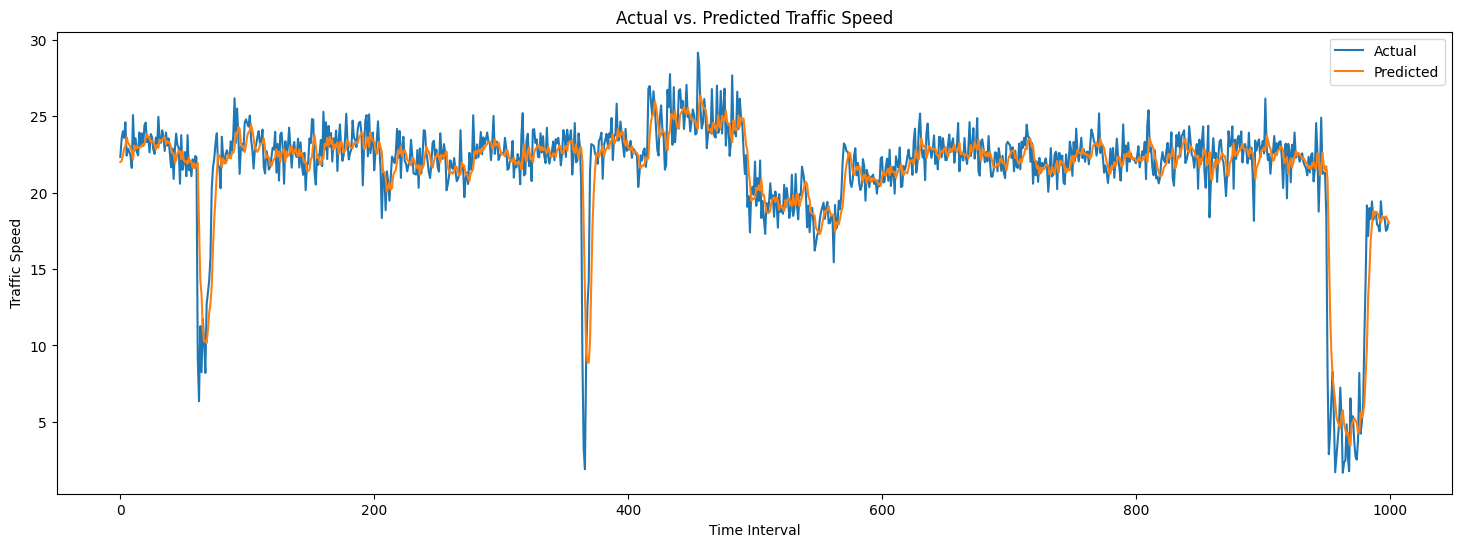

In [27]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 15 Minute Time Window

In [28]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [29]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
lr_15m_pred = lr_model.predict(X_val_scaled)

In [33]:
eval_metrics(y_val, lr_15m_pred,n,p)

Mean Absolute Error: 0.92593815820333
Mean Squared Error: 1.8389615042067537
Root Mean Squared Error: 1.3560831479694575
R2 Score: 0.8160321804168431
Adjusted R2 Score: 0.8160224757324808
explained_variance_score: 0.8160346600818977


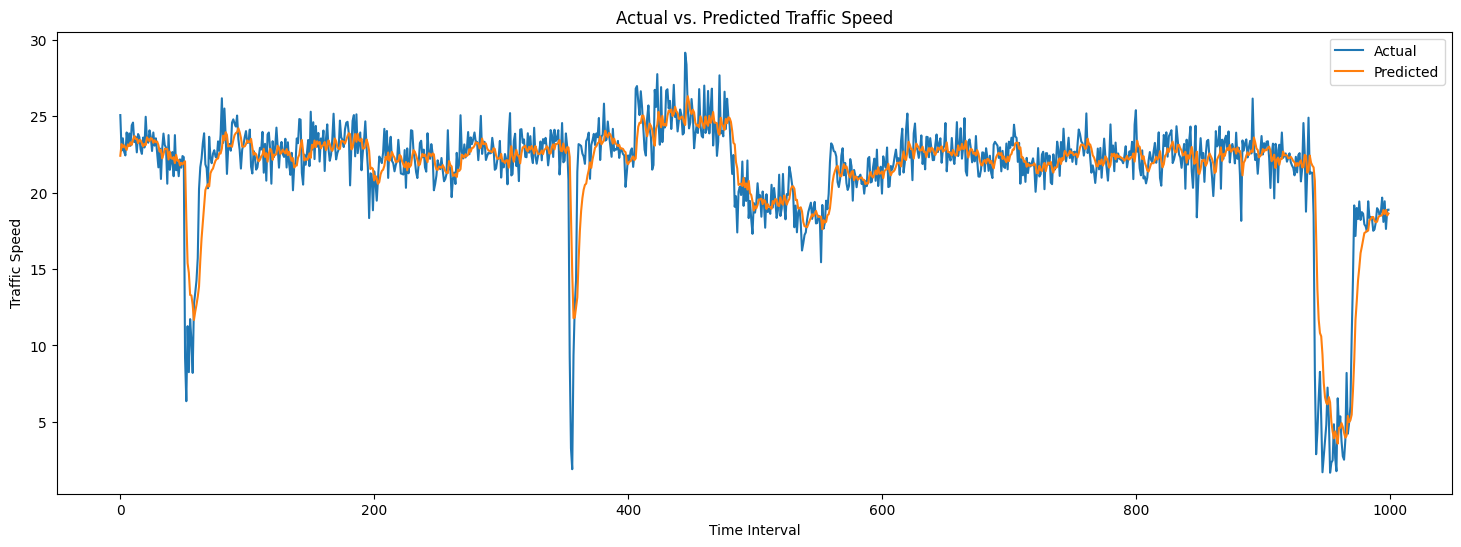

In [34]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 30 Minute Window

In [35]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [36]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [37]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [38]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [39]:
lr_30m_pred = lr_model.predict(X_val_scaled)

In [40]:
eval_metrics(y_val, lr_30m_pred,n,p)

Mean Absolute Error: 0.9269432852472242
Mean Squared Error: 1.842384590166213
Root Mean Squared Error: 1.357344683625428
R2 Score: 0.8156852457965513
Adjusted R2 Score: 0.8156657977729367
explained_variance_score: 0.8156870129189562


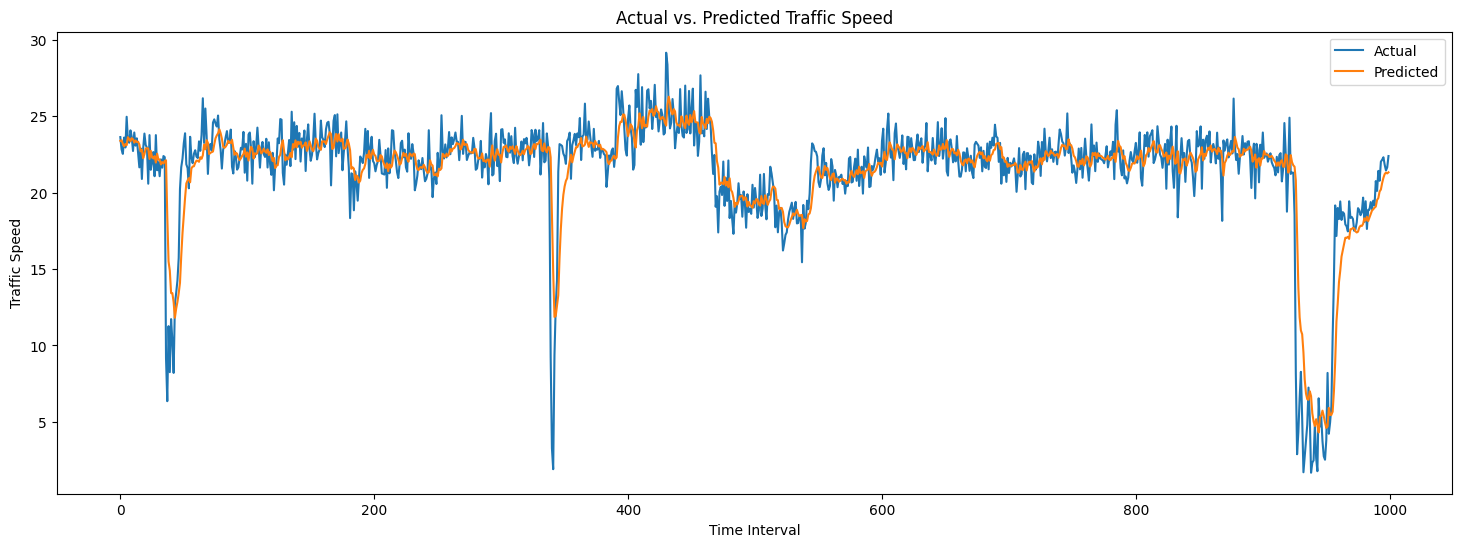

In [41]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 60 Minutes

In [42]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [43]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [44]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [45]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [46]:
lr_60m_pred = lr_model.predict(X_val_scaled)

In [47]:
eval_metrics(y_val, lr_60m_pred,n,p)

Mean Absolute Error: 0.9281218127315537
Mean Squared Error: 1.8448030067669345
Root Mean Squared Error: 1.3582352545737186
R2 Score: 0.8154353197429569
Adjusted R2 Score: 0.8153963627325705
explained_variance_score: 0.8154363442422047


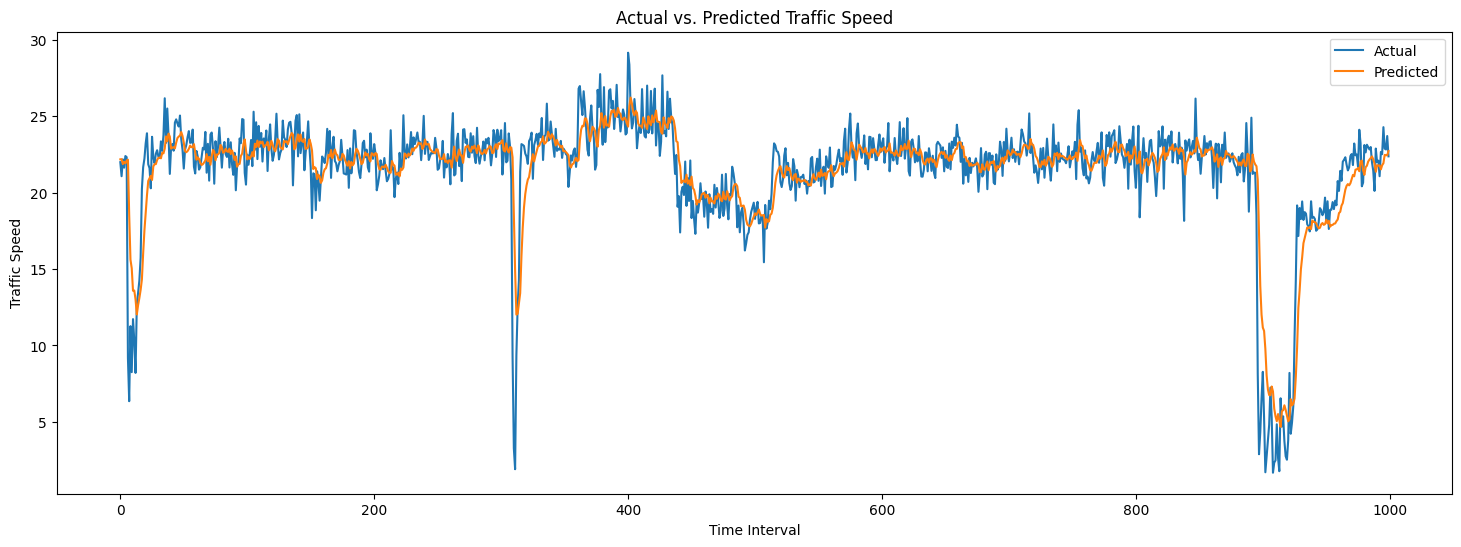

In [48]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

# ---------------------------------------------------------------

## Vanilla LSTM

#### 5 Minute Time Window

In [49]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [50]:
vlstm_5m_model = Sequential()
vlstm_5m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_5m_model.add(Dense(1))
vlstm_5m_model.compile(optimizer='adam', loss='mean_squared_error')

vlstm_5m_model.fit(X_train_scaled,y_train,epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5085/5085 [==============================] - 66s 13ms/step - loss: 8.1212 - val_loss: 2.9022
Epoch 2/50
5085/5085 [==============================] - 55s 11ms/step - loss: 2.0157 - val_loss: 2.0786
Epoch 3/50
5085/5085 [==============================] - 58s 11ms/step - loss: 1.9131 - val_loss: 1.8947
Epoch 4/50
5085/5085 [==============================] - 60s 12ms/step - loss: 1.8657 - val_loss: 1.8766
Epoch 5/50
5085/5085 [==============================] - 60s 12ms/step - loss: 1.8453 - val_loss: 1.9380
Epoch 6/50
5085/5085 [==============================] - 53s 10ms/step - loss: 1.8324 - val_loss: 1.8614
Epoch 7/50
5085/5085 [==============================] - 55s 11ms/step - loss: 1.8204 - val_loss: 1.8116
Epoch 8/50
5085/5085 [==============================] - 55s 11ms/step - loss: 1.8155 - val_loss: 1.8938
Epoch 9/50
5085/5085 [==============================] - 59s 12ms/step - loss: 1.8111 - val_loss: 1.9150
Epoch 10/50
5085/5085 [==============================] - 60s 12m

In [51]:
vlstm_5m_pred = vlstm_5m_model.predict(X_val_scaled)

8887/8887 [==============================] - 22s 2ms/step


In [52]:
eval_metrics(y_val, vlstm_5m_pred,n,p)

Mean Absolute Error: 0.9272458593143339
Mean Squared Error: 1.7506845883664863
Root Mean Squared Error: 1.323134380313083
R2 Score: 0.8248687582784596
Adjusted R2 Score: 0.8248656789828661
explained_variance_score: 0.8251112324468637


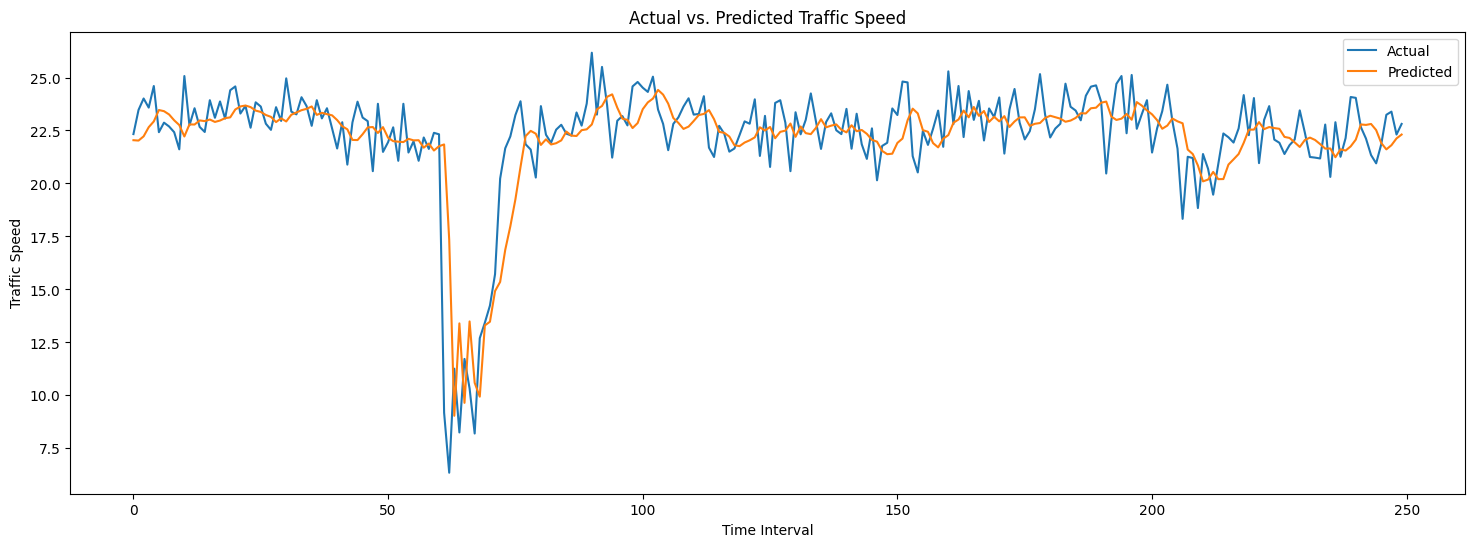

In [53]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 15 Minute Time Window

In [54]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [55]:
vlstm_15m_model = Sequential()
vlstm_15m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_15m_model.add(Dense(1))
vlstm_15m_model.compile(optimizer='adam', loss='mean_squared_error')

# vlstm_15m_model.fit(X_train_scaled,y_train,epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))
vlstm_15m_model.fit(X_train_scaled,y_train,epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5084/5084 [==============================] - 153s 30ms/step - loss: 6.2517 - val_loss: 3.1334
Epoch 2/50
5084/5084 [==============================] - 178s 35ms/step - loss: 2.1924 - val_loss: 2.5955
Epoch 3/50
5084/5084 [==============================] - 162s 32ms/step - loss: 2.0829 - val_loss: 2.3524
Epoch 4/50
5084/5084 [==============================] - 164s 32ms/step - loss: 1.9710 - val_loss: 2.4227
Epoch 5/50
5084/5084 [==============================] - 512s 101ms/step - loss: 1.8483 - val_loss: 1.8464
Epoch 6/50
5084/5084 [==============================] - 97s 19ms/step - loss: 1.7876 - val_loss: 1.8150
Epoch 7/50
5084/5084 [==============================] - 142s 28ms/step - loss: 1.7689 - val_loss: 2.0076
Epoch 8/50
5084/5084 [==============================] - 143s 28ms/step - loss: 1.7492 - val_loss: 1.8154
Epoch 9/50
5084/5084 [==============================] - 145s 29ms/step - loss: 1.7384 - val_loss: 1.8200
Epoch 10/50
5084/5084 [==============================] 

In [56]:
vlstm_15m_pred = vlstm_15m_model.predict(X_val_scaled)

8887/8887 [==============================] - 42s 5ms/step


In [57]:
eval_metrics(y_val, vlstm_15m_pred,n,p)

Mean Absolute Error: 0.8993953492901906
Mean Squared Error: 1.6598492641145564
Root Mean Squared Error: 1.288351374476139
R2 Score: 0.8339503849007538
Adjusted R2 Score: 0.8339416254388725
explained_variance_score: 0.8345494354202654


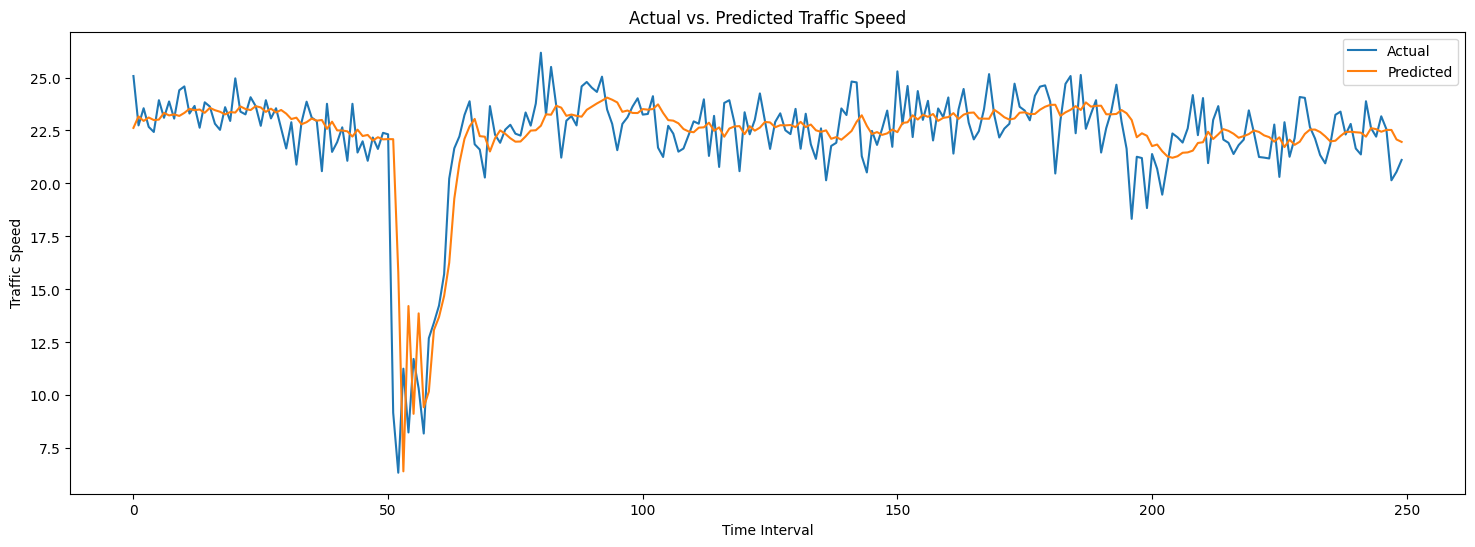

In [58]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 30 Minute Time Window

In [59]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [61]:
vlstm_30m_model = Sequential()
vlstm_30m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_30m_model.add(Dense(1))
vlstm_30m_model.compile(optimizer='adam', loss='mean_squared_error')

# vlstm_30m_model.fit(X_train_scaled,y_train,epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))
vlstm_30m_model.fit(X_train_scaled,y_train,epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5084/5084 [==============================] - 138s 27ms/step - loss: 5.3195 - val_loss: 2.2153
Epoch 2/50
5084/5084 [==============================] - 155s 30ms/step - loss: 2.0451 - val_loss: 2.1023
Epoch 3/50
5084/5084 [==============================] - 137s 27ms/step - loss: 1.8657 - val_loss: 1.8320
Epoch 4/50
5084/5084 [==============================] - 139s 27ms/step - loss: 1.7911 - val_loss: 1.9084
Epoch 5/50
5084/5084 [==============================] - 130s 26ms/step - loss: 1.7617 - val_loss: 1.7612
Epoch 6/50
5084/5084 [==============================] - 133s 26ms/step - loss: 1.8112 - val_loss: 1.7574
Epoch 7/50
5084/5084 [==============================] - 130s 26ms/step - loss: 1.7397 - val_loss: 1.7788
Epoch 8/50
5084/5084 [==============================] - 130s 26ms/step - loss: 1.7360 - val_loss: 1.7173
Epoch 9/50
5084/5084 [==============================] - 136s 27ms/step - loss: 1.7183 - val_loss: 1.8206
Epoch 10/50
5084/5084 [==============================] 

In [62]:
vlstm_30m_pred = vlstm_30m_model.predict(X_val_scaled)

8886/8886 [==============================] - 51s 6ms/step


In [63]:
eval_metrics(y_val, vlstm_30m_pred,n,p)

Mean Absolute Error: 0.8999787455241417
Mean Squared Error: 1.6771719181419316
Root Mean Squared Error: 1.2950567239090076
R2 Score: 0.8322133546387465
Adjusted R2 Score: 0.8321956505832284
explained_variance_score: 0.832218196126706


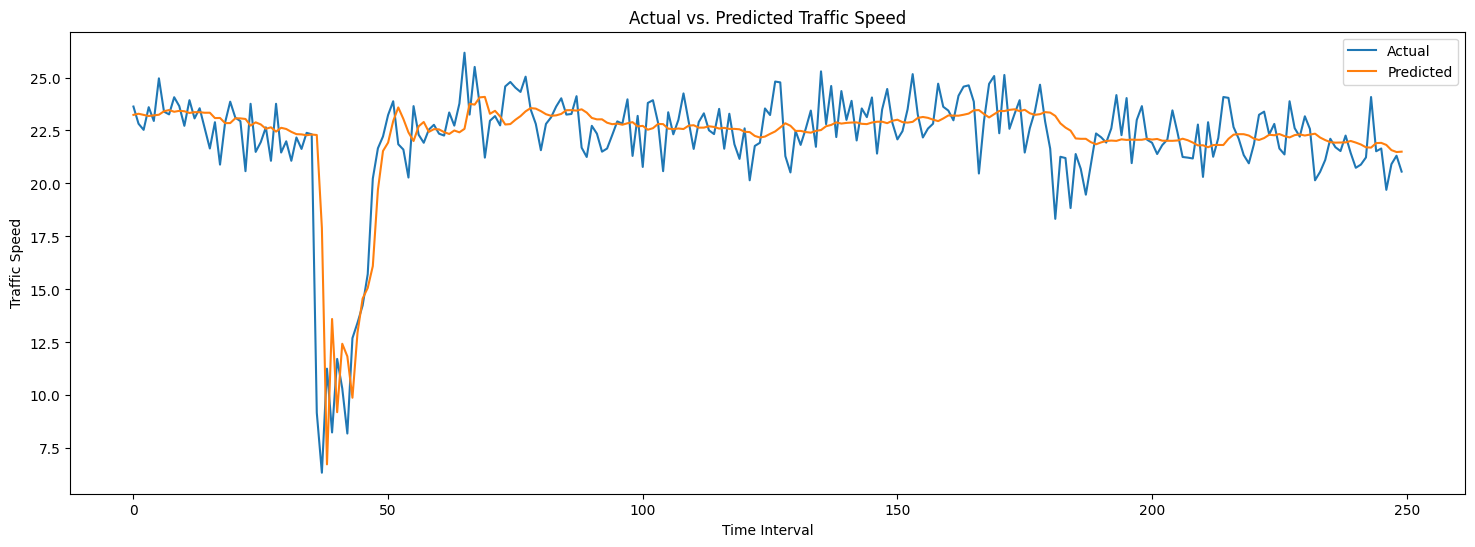

In [64]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

## RNN

#### 5 Minute Time Window

In [65]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [66]:
rnn_5m_model = Sequential()
rnn_5m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_5m_model.add(Dense(1))
rnn_5m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_5m_model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5085/5085 [==============================] - 22s 4ms/step - loss: 7.5407 - val_loss: 2.0709
Epoch 2/50
5085/5085 [==============================] - 24s 5ms/step - loss: 1.9685 - val_loss: 2.0449
Epoch 3/50
5085/5085 [==============================] - 19s 4ms/step - loss: 1.9206 - val_loss: 1.9774
Epoch 4/50
5085/5085 [==============================] - 17s 3ms/step - loss: 1.8795 - val_loss: 1.8854
Epoch 5/50
5085/5085 [==============================] - 17s 3ms/step - loss: 1.8533 - val_loss: 1.8757
Epoch 6/50
5085/5085 [==============================] - 17s 3ms/step - loss: 1.8390 - val_loss: 2.0620
Epoch 7/50
5085/5085 [==============================] - 18s 3ms/step - loss: 1.8287 - val_loss: 1.8144
Epoch 8/50
5085/5085 [==============================] - 18s 3ms/step - loss: 1.8247 - val_loss: 1.8054
Epoch 9/50
5085/5085 [==============================] - 17s 3ms/step - loss: 1.8162 - val_loss: 1.8097
Epoch 10/50
5085/5085 [==============================] - 17s 3ms/step - l

In [67]:
rnn_5m_pred = rnn_5m_model.predict(X_val_scaled)

8887/8887 [==============================] - 14s 2ms/step


In [68]:
eval_metrics(y_val, rnn_5m_pred,n,p)

Mean Absolute Error: 0.9267788862388696
Mean Squared Error: 1.7355154898745908
Root Mean Squared Error: 1.3173896499800621
R2 Score: 0.8263862121204225
Adjusted R2 Score: 0.8263831595058991
explained_variance_score: 0.8278434430927893


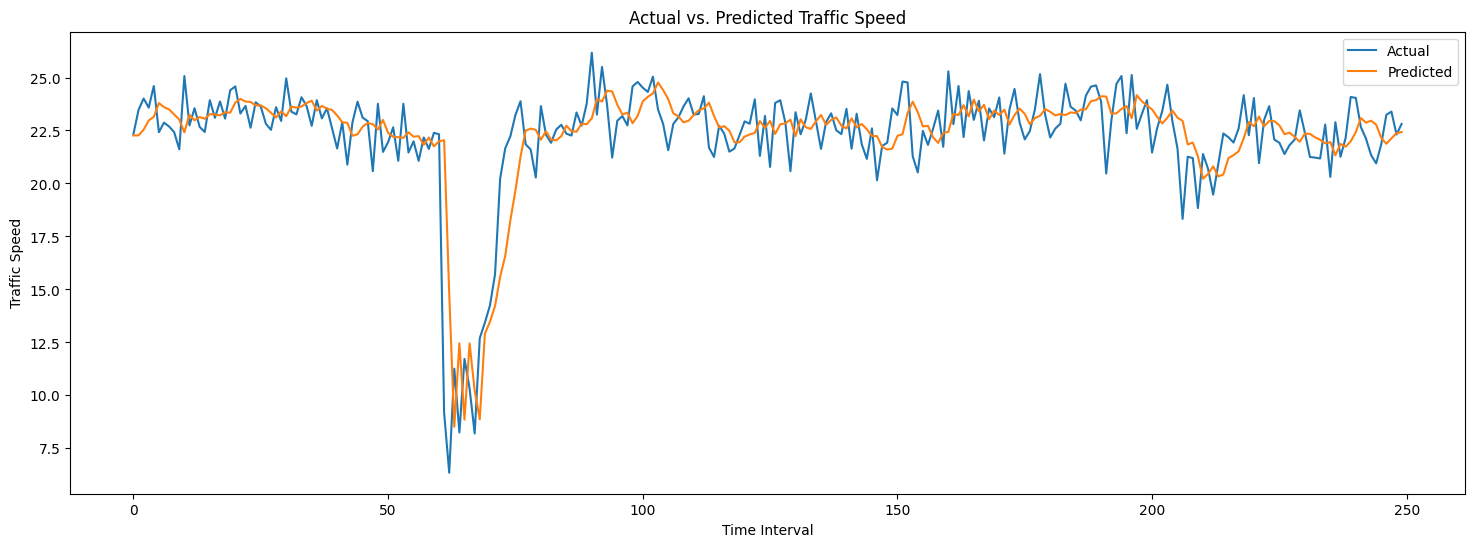

In [69]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 15 Minute Time Window

In [70]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [71]:
rnn_15m_model = Sequential()
rnn_15m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_15m_model.add(Dense(1))
rnn_15m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_15m_model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5084/5084 [==============================] - 26s 5ms/step - loss: 4.2606 - val_loss: 2.4321
Epoch 2/50
5084/5084 [==============================] - 33s 6ms/step - loss: 2.0657 - val_loss: 2.1644
Epoch 3/50
5084/5084 [==============================] - 32s 6ms/step - loss: 1.9575 - val_loss: 2.0257
Epoch 4/50
5084/5084 [==============================] - 31s 6ms/step - loss: 1.9077 - val_loss: 2.0007
Epoch 5/50
5084/5084 [==============================] - 32s 6ms/step - loss: 1.8750 - val_loss: 2.0999
Epoch 6/50
5084/5084 [==============================] - 33s 6ms/step - loss: 1.8408 - val_loss: 2.0155
Epoch 7/50
5084/5084 [==============================] - 32s 6ms/step - loss: 1.8133 - val_loss: 2.2169
Epoch 8/50
5084/5084 [==============================] - 32s 6ms/step - loss: 1.7909 - val_loss: 1.8094
Epoch 9/50
5084/5084 [==============================] - 31s 6ms/step - loss: 1.7820 - val_loss: 1.8027
Epoch 10/50
5084/5084 [==============================] - 32s 6ms/step - l

In [72]:
rnn_15m_pred = rnn_15m_model.predict(X_val_scaled)

8887/8887 [==============================] - 21s 2ms/step


In [73]:
eval_metrics(y_val, rnn_15m_pred,n,p)

Mean Absolute Error: 0.9054381292742163
Mean Squared Error: 1.676458583077857
Root Mean Squared Error: 1.2947812877385343
R2 Score: 0.8322888056956156
Adjusted R2 Score: 0.8322799585819821
explained_variance_score: 0.833975713914817


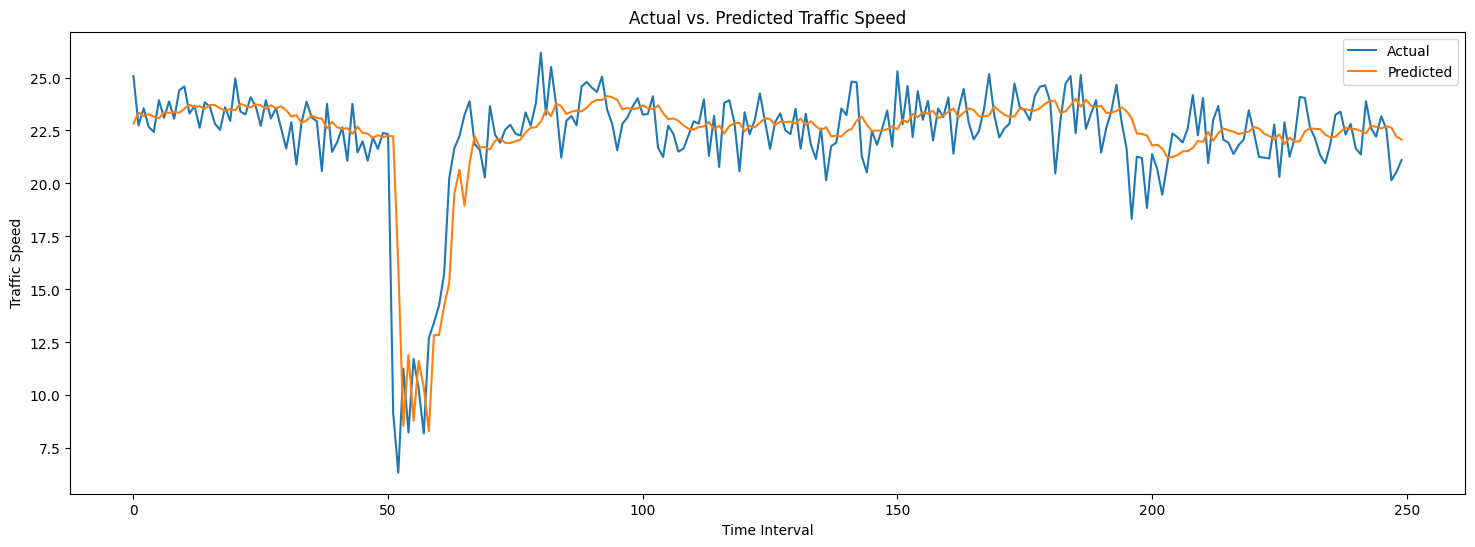

In [74]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 30 Minute Time Window

In [75]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [76]:
rnn_30m_model = Sequential()
rnn_30m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_30m_model.add(Dense(1))
rnn_30m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_30m_model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5084/5084 [==============================] - 82s 16ms/step - loss: 5.3340 - val_loss: 3.1861
Epoch 2/50
5084/5084 [==============================] - 81s 16ms/step - loss: 2.0837 - val_loss: 2.3045
Epoch 3/50
5084/5084 [==============================] - 79s 16ms/step - loss: 1.9235 - val_loss: 2.0548
Epoch 4/50
5084/5084 [==============================] - 82s 16ms/step - loss: 1.8389 - val_loss: 1.9864
Epoch 5/50
5084/5084 [==============================] - 82s 16ms/step - loss: 1.7953 - val_loss: 1.7614
Epoch 6/50
5084/5084 [==============================] - 60s 12ms/step - loss: 1.7651 - val_loss: 1.7688
Epoch 7/50
5084/5084 [==============================] - 52s 10ms/step - loss: 1.7436 - val_loss: 1.7734
Epoch 8/50
5084/5084 [==============================] - 63s 12ms/step - loss: 1.7308 - val_loss: 1.7811
Epoch 9/50
5084/5084 [==============================] - 64s 13ms/step - loss: 1.7240 - val_loss: 1.6882
Epoch 10/50
5084/5084 [==============================] - 53s 10m

In [77]:
rnn_30m_pred = rnn_30m_model.predict(X_val_scaled)

8886/8886 [==============================] - 33s 4ms/step


In [78]:
eval_metrics(y_val, rnn_30m_pred,n,p)

Mean Absolute Error: 0.9288020891494946
Mean Squared Error: 1.7391495820693328
Root Mean Squared Error: 1.3187682063461088
R2 Score: 0.8260130216822859
Adjusted R2 Score: 0.8259946633968757
explained_variance_score: 0.8319905193609942


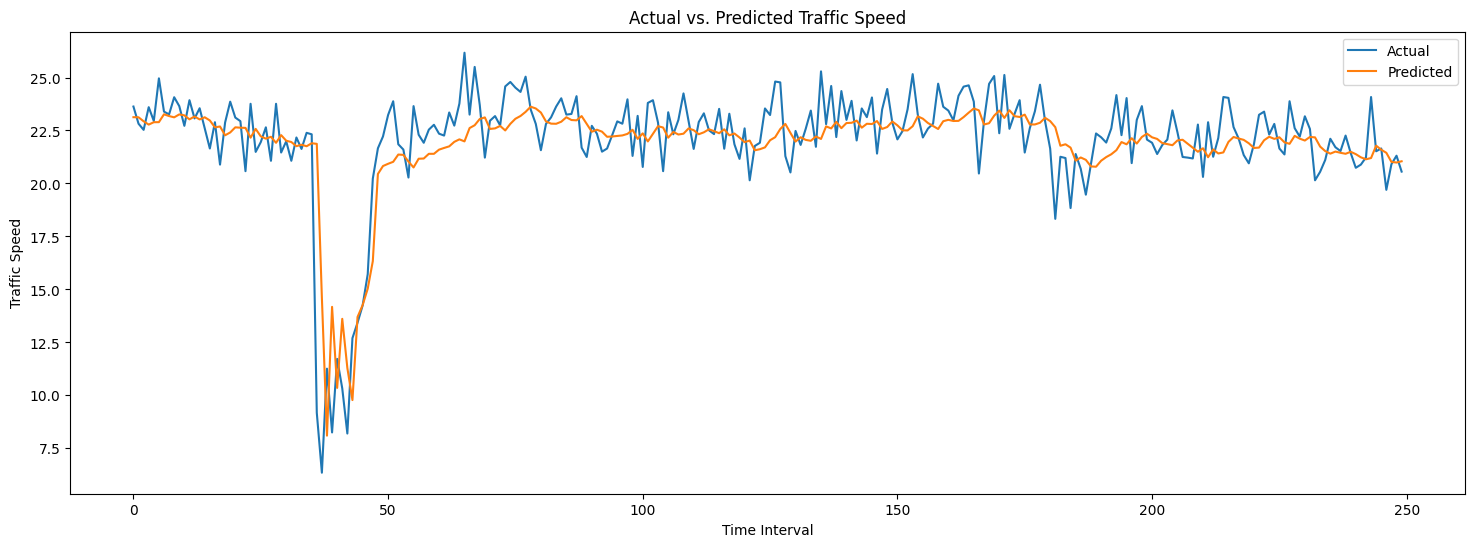

In [79]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 60 Minute Time Window

In [80]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

In [81]:
rnn_60m_model = Sequential()
rnn_60m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_60m_model.add(Dense(1))
rnn_60m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_60m_model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, validation_data=(X_val_scaled, y_val))

Epoch 1/50
5084/5084 [==============================] - 137s 27ms/step - loss: 5.3877 - val_loss: 4.0519
Epoch 2/50
5084/5084 [==============================] - 120s 24ms/step - loss: 2.3721 - val_loss: 2.3112
Epoch 3/50
5084/5084 [==============================] - 118s 23ms/step - loss: 1.9800 - val_loss: 2.0304
Epoch 4/50
5084/5084 [==============================] - 122s 24ms/step - loss: 1.8829 - val_loss: 1.9926
Epoch 5/50
5084/5084 [==============================] - 112s 22ms/step - loss: 1.8199 - val_loss: 1.8553
Epoch 6/50
5084/5084 [==============================] - 111s 22ms/step - loss: 1.7673 - val_loss: 1.7364
Epoch 7/50
5084/5084 [==============================] - 113s 22ms/step - loss: 1.7378 - val_loss: 1.7969
Epoch 8/50
5084/5084 [==============================] - 116s 23ms/step - loss: 1.7237 - val_loss: 1.6865
Epoch 9/50
5084/5084 [==============================] - 117s 23ms/step - loss: 3.2060 - val_loss: 2.0709
Epoch 10/50
5084/5084 [==============================] 

In [82]:
rnn_60m_pred = rnn_60m_model.predict(X_val_scaled)

8885/8885 [==============================] - 27s 3ms/step


In [83]:
eval_metrics(y_val, rnn_60m_pred,n,p)

Mean Absolute Error: 0.900331581589558
Mean Squared Error: 1.664909699080708
Root Mean Squared Error: 1.29031379868647
R2 Score: 0.833432878664805
Adjusted R2 Score: 0.8333977204911671
explained_variance_score: 0.8339425766771651


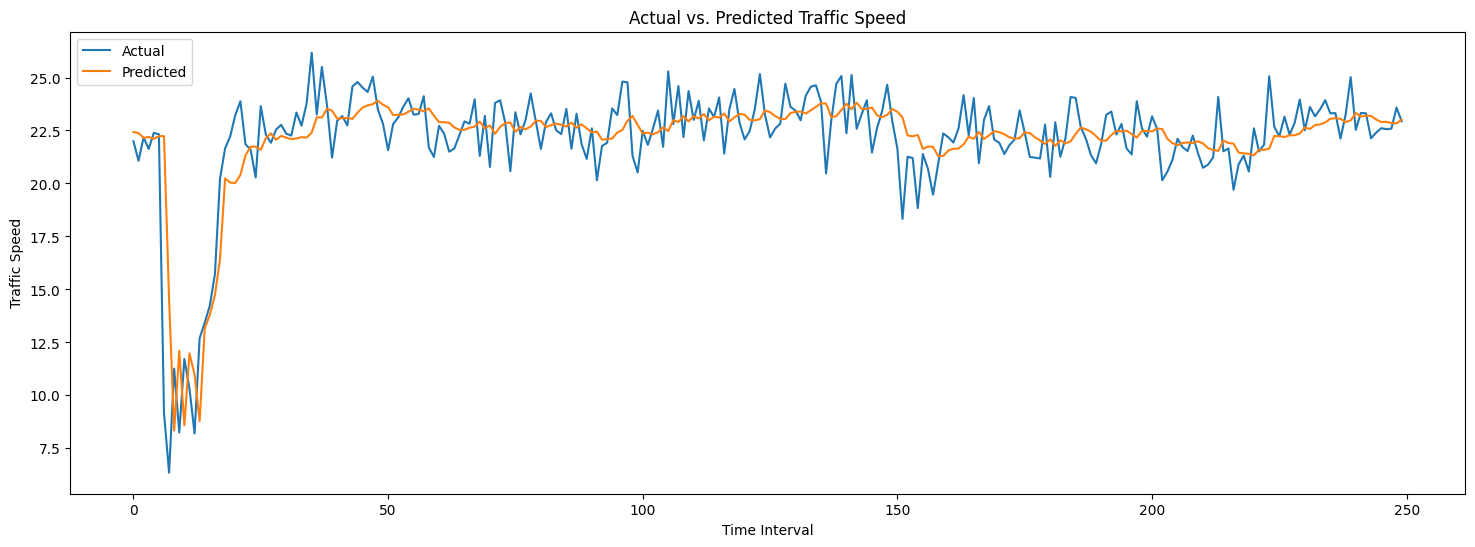

In [84]:
plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

# ---------------------------------------------------------------

## XGBRegressor

#### 5 minute

In [85]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [86]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [87]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [88]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [89]:
xgb_5m_pred = xgb_model.predict(X_val_scaled)

In [90]:
eval_metrics(y_val, xgb_5m_pred,n,p)

Mean Absolute Error: 1.2601058710120572
Mean Squared Error: 2.66283933155401
Root Mean Squared Error: 1.6318208638064442
R2 Score: 0.7336205723527018
Adjusted R2 Score: 0.7336158886595487
explained_variance_score: 0.8197133497230789


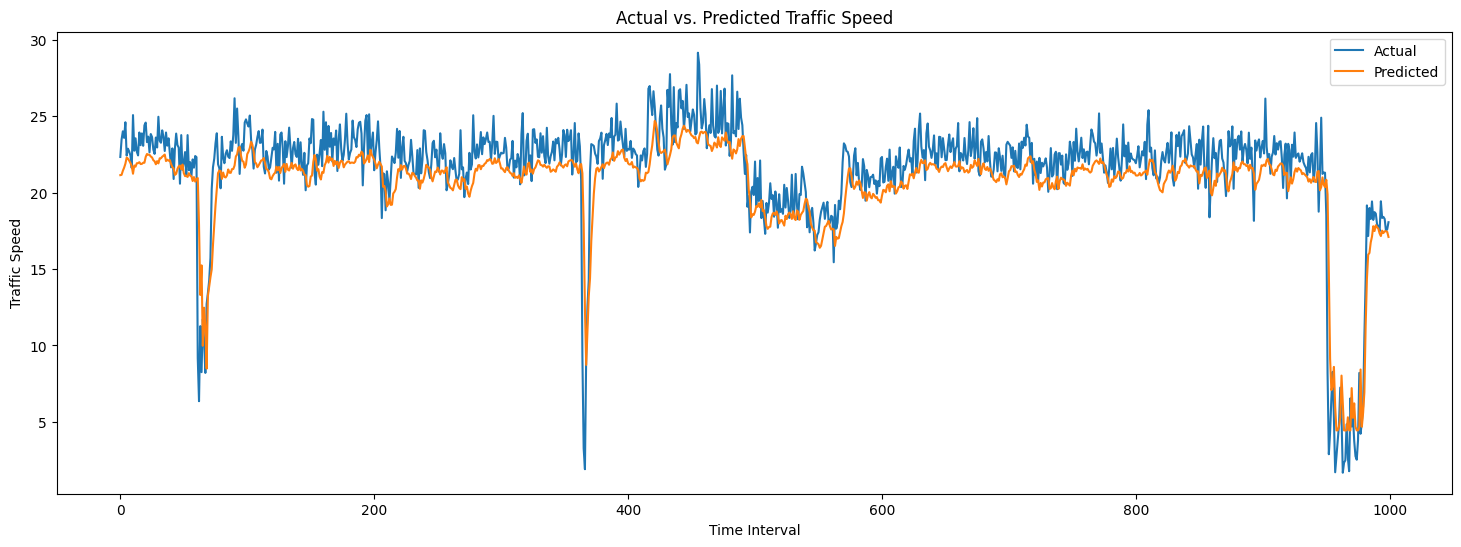

In [91]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 15 minute

In [92]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [93]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [94]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [95]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [96]:
xgb_15m_pred = xgb_model.predict(X_val_scaled)

In [97]:
eval_metrics(y_val, xgb_15m_pred,n,p)

Mean Absolute Error: 1.2489285535479189
Mean Squared Error: 2.626415498922725
Root Mean Squared Error: 1.6206219481799957
R2 Score: 0.7372560917936979
Adjusted R2 Score: 0.7372422315071376
explained_variance_score: 0.8234868273865138


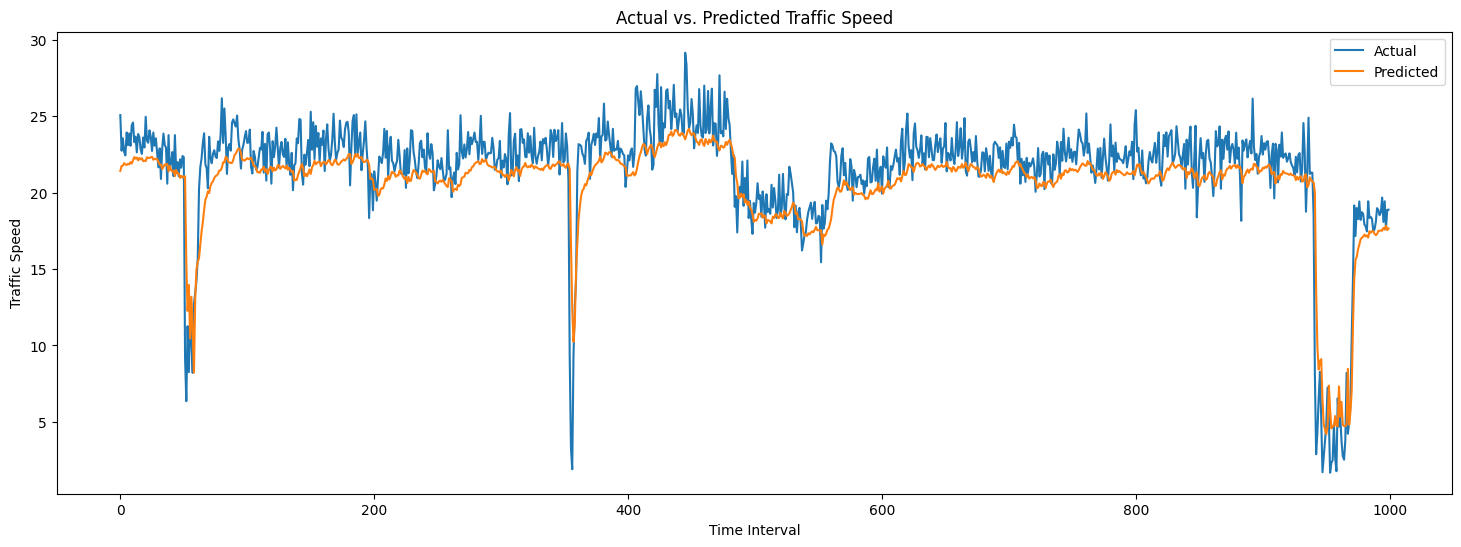

In [98]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 30 minute

In [99]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [100]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [101]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [102]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [103]:
xgb_30m_pred = xgb_model.predict(X_val_scaled)

In [104]:
eval_metrics(y_val, xgb_30m_pred,n,p)

Mean Absolute Error: 1.2490379796526025
Mean Squared Error: 2.6295289680329925
Root Mean Squared Error: 1.6215822421428376
R2 Score: 0.7369382114892066
Adjusted R2 Score: 0.7369104544499115
explained_variance_score: 0.8232167101310687


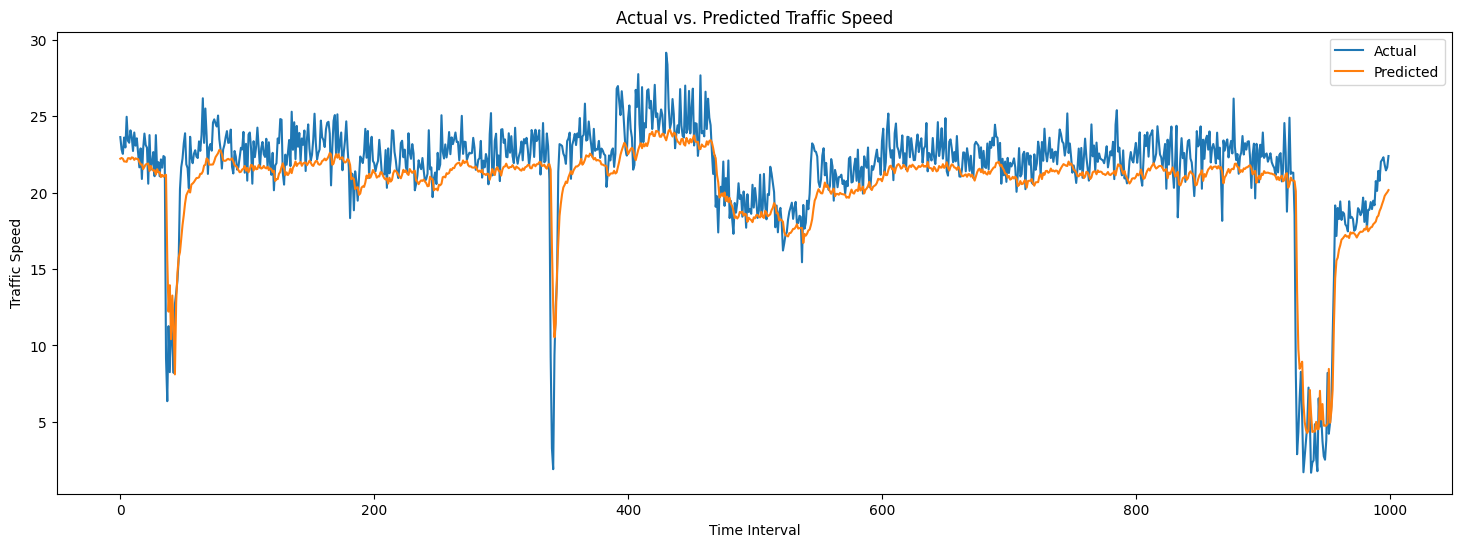

In [105]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 60 minute

In [106]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [107]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [108]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [109]:
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [110]:
xgb_60m_pred = xgb_model.predict(X_val_scaled)

In [111]:
eval_metrics(y_val, xgb_60m_pred,n,p)

Mean Absolute Error: 1.248948884171452
Mean Squared Error: 2.629419145626696
Root Mean Squared Error: 1.6215483790583296
R2 Score: 0.7369378182417234
Adjusted R2 Score: 0.7368822923624883
explained_variance_score: 0.8233069824046567


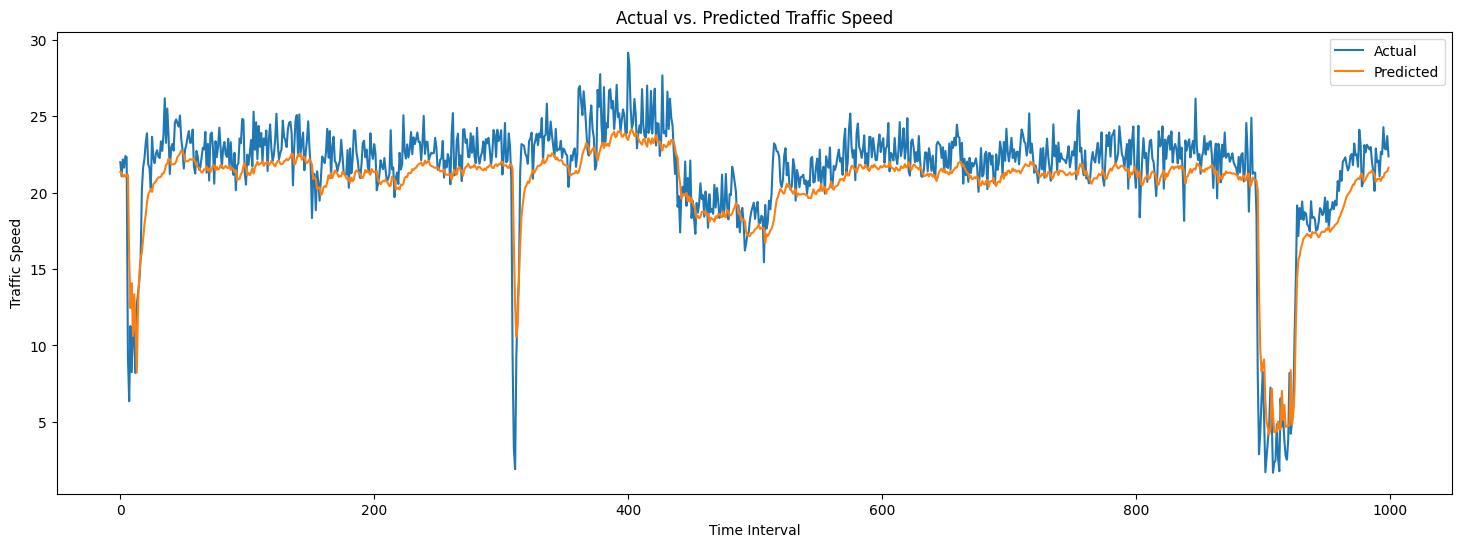

In [112]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

## Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor

#### 5 minute

In [114]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [115]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [116]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [117]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_5m_pred = rf_model.predict(X_val_scaled)

In [118]:
eval_metrics(y_val, rf_5m_pred,n,p)

Mean Absolute Error: 1.1123222333779201
Mean Squared Error: 2.4197382413715665
Root Mean Squared Error: 1.5555507839256058
R2 Score: 0.757939399439217
Adjusted R2 Score: 0.7579351433388586
explained_variance_score: 0.7579584333421834


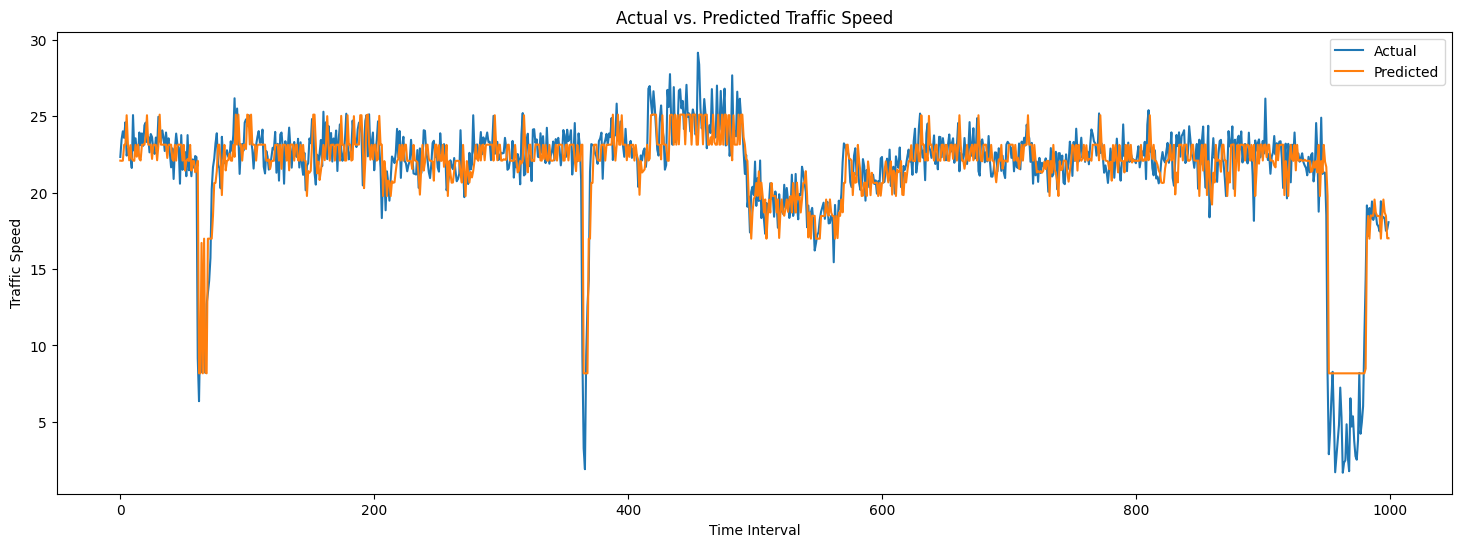

In [119]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 15 minute

In [120]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [121]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [122]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [123]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_15m_pred = rf_model.predict(X_val_scaled)

In [124]:
eval_metrics(y_val, rf_15m_pred,n,p)

Mean Absolute Error: 1.1118588000045708
Mean Squared Error: 2.4195248725618916
Root Mean Squared Error: 1.5554821993715942
R2 Score: 0.7579532175011846
Adjusted R2 Score: 0.7579404490309685
explained_variance_score: 0.7579735279542698


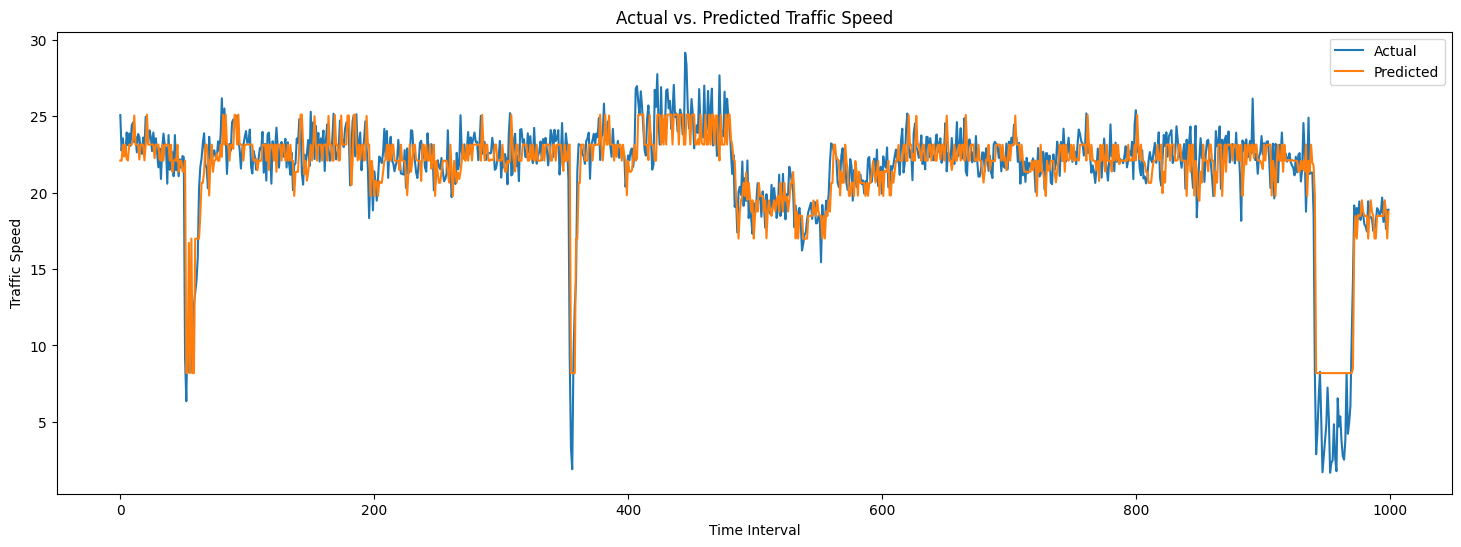

In [125]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 30 minute

In [126]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [127]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [128]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [129]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_30m_pred = rf_model.predict(X_val_scaled)

In [130]:
eval_metrics(y_val, rf_30m_pred,n,p)

Mean Absolute Error: 1.1130332506963687
Mean Squared Error: 2.4234369691339683
Root Mean Squared Error: 1.5567392103798146
R2 Score: 0.7575559458770871
Adjusted R2 Score: 0.7575303643238891
explained_variance_score: 0.7575759832320024


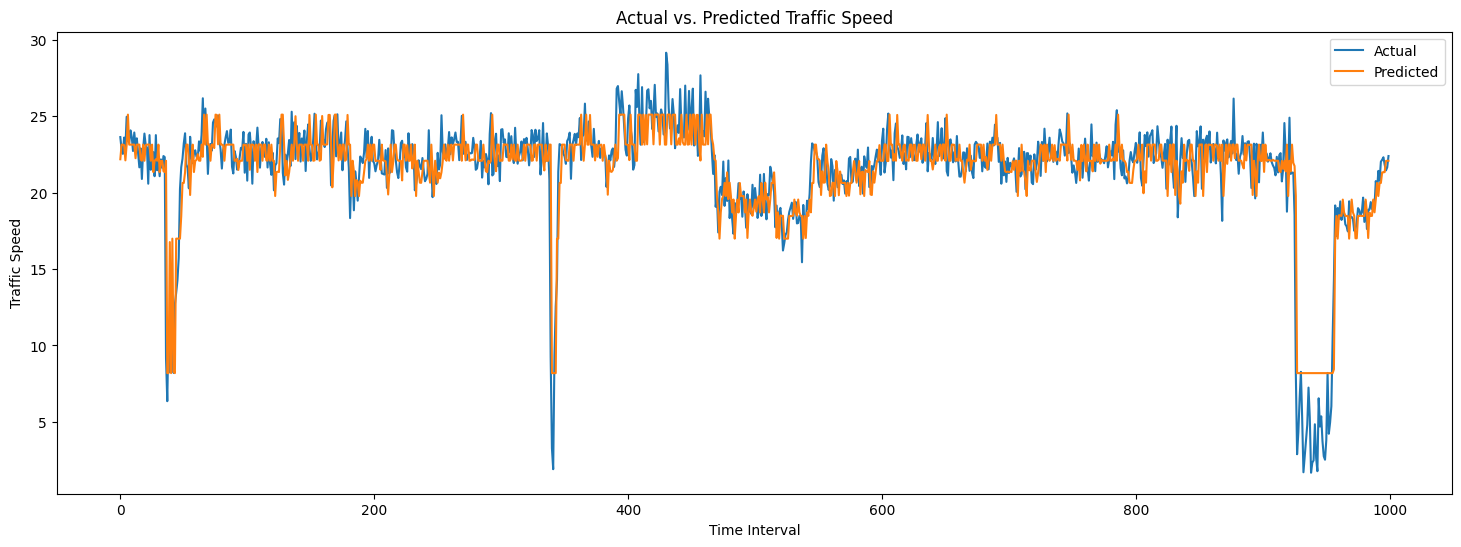

In [131]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()

#### 60 minute

In [132]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

In [133]:
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [134]:
n = len(y_val)
p = X_val_scaled.shape[1]

In [135]:
rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_60m_pred = rf_model.predict(X_val_scaled)

In [136]:
eval_metrics(y_val, rf_60m_pred,n,p)

Mean Absolute Error: 1.1133222265079237
Mean Squared Error: 2.422151294995055
Root Mean Squared Error: 1.5563262174091443
R2 Score: 0.7576740835443452
Adjusted R2 Score: 0.7576229345746122
explained_variance_score: 0.7576932482258193


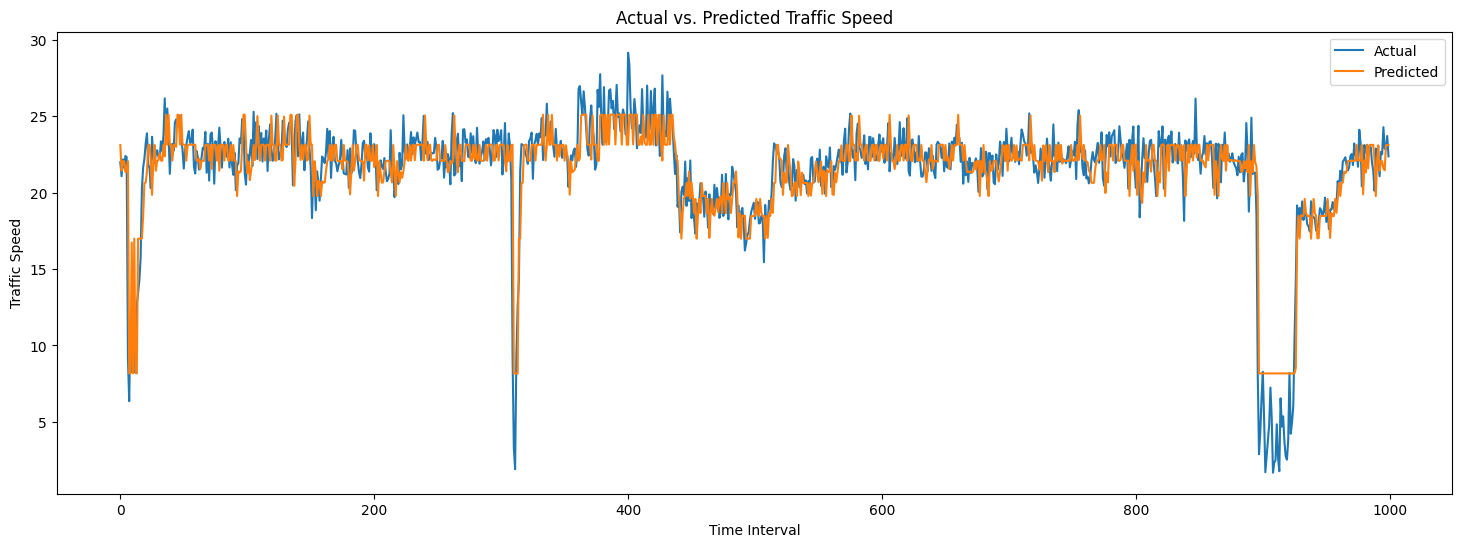

In [137]:
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Speed')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Speed')
plt.show()